### Agentic RAG

In [24]:
"""
STEP 3: Environment Setup
Load API credentials securely from environment variables.
"""

import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get Google API key with error handling
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
if not GOOGLE_API_KEY:
    raise ValueError("GOOGLE_API_KEY not found in environment variables")
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
if not TAVILY_API_KEY:
    raise ValueError("TAVILY_API_KEY not found in environment variables")
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
if not LANGSMITH_API_KEY:
    raise ValueError("LANGSMITH_API_KEY not found in environment variables")

print("✓ API keys loaded successfully")

✓ API keys loaded successfully


In [2]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Initialize Google embeddings model for vector representation
embedding_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001", 
    google_api_key=GOOGLE_API_KEY
)


# Initialize Google's Gemini model for response generation
llm = ChatGoogleGenerativeAI(
    google_api_key=GOOGLE_API_KEY,
    model="gemini-2.0-flash",    # Latest fast Gemini model for quick reranking
    temperature=0,               # Deterministic output for consistency in ranking
    max_tokens=None,            # Use model default token limit
    timeout=None,               # No timeout limit for ranking requests
    max_retries=2,              # Retry failed requests twice
)

print("✓ Gemini model initialized for reranking")

/home/bjit/Desktop/Storage01/SelfDevelopment/Rag_Course/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Gemini model initialized for reranking


In [4]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [5]:
urls=[
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nWorkflows & agents\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\n            \n            \nThese docs will be deprecated and removed with the release of LangGraph v1.0 in October 2025. Visit the v1.0 alpha docs\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Workflows & agents\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          

In [7]:
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

## Add alll these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embedding_model
)


retriever=vectorstore.as_retriever()

In [8]:
retriever.invoke("what is langgraph")

[Document(id='e7ec4a74-20f9-41b8-be9a-0578f0554c7b', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='LangSmith Trace\nhttps://smith.langchain.com/public/abab6a44-29f6-4b97-8164-af77413e494d/r\nWhat LangGraph provides¶\nBy constructing each of the above in LangGraph, we get a few things:\nPersistence: Human-in-the-Loop¶\nLangGraph persistence layer supports interruption and approval of actions (e.g., Human In The Loop). See Module 3 of LangChain Academy.\nPersistence: Memory¶\nLangGraph persistence layer supports conversational (short-term) memory and long-term memory. See Modules 2 and 5 of LangChain Academy:\nStreaming¶\nLangGraph provides several ways to stream workflow / agent outputs or intermediate state. See Module 3 of LangChain Academy.\nDeployment¶\nLangGraph provides an easy on-ramp for deployment

In [11]:
### Retriever To Retriever Tools
from langchain.tools.retriever import create_retriever_tool
retriever_tool=create_retriever_tool(
    retriever=retriever,
    name="retriever_vector_db_blog",
    description="Search and run information about Langgraph"
)

In [10]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and run information about Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x7d6cec1b4900>, retriever=VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7d6ced411700>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x7d6cec1b5c60>, retriever=VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7d6ced411700>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_cont

### Langchain Blogs- Seperate Vector Store


In [12]:
langchain_urls=[
    "https://python.langchain.com/docs/tutorials/",
    "https://python.langchain.com/docs/tutorials/chatbot/",
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"
]

docs=[WebBaseLoader(url).load() for url in langchain_urls]
docs

[[Document(metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'Tutorials | 🦜️🔗 LangChain', 'description': 'New to LangChain or LLM app development in general? Read this material to quickly get up and running building your first applications.', 'language': 'en'}, page_content='\n\n\n\n\nTutorials | 🦜️🔗 LangChain\n\n\n\n\n\n\n\n\nSkip to main contentThese docs will be deprecated and no longer maintained with the release of LangChain v1.0 in October 2025. Visit the v1.0 alpha docsIntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engine

In [14]:
import time

docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=100
)

doc_splits = text_splitter.split_documents(docs_list)

print(f"Processing {len(doc_splits)} LangChain document chunks in batches of 5...")

# Process documents in batches of 5 to respect API limits
batch_size = 5

for i in range(0, len(doc_splits), batch_size):
    batch = doc_splits[i:i + batch_size]
    print(f"Processing LangChain batch {i//batch_size + 1}/{(len(doc_splits) + batch_size - 1)//batch_size}")
    
    # Create vectorstore for this batch
    if i == 0:
        # Create initial vectorstore with first batch
        vectorstorelangchain = FAISS.from_documents(
            documents=batch,
            embedding=embedding_model
        )
    else:
        # Add remaining batches to existing vectorstore
        batch_vectorstore = FAISS.from_documents(
            documents=batch,
            embedding=embedding_model
        )
        vectorstorelangchain.merge_from(batch_vectorstore)
    
    # Wait after every batch of 5 embeddings
    if i + batch_size < len(doc_splits):  # Don't wait after the last batch
        print("Waiting 2 seconds before next batch...")
        time.sleep(2)

retrieverlangchain = vectorstorelangchain.as_retriever()
print("✓ LangChain vectorstore and retriever created successfully")

Processing 103 LangChain document chunks in batches of 5...
Processing LangChain batch 1/21
Waiting 2 seconds before next batch...
Processing LangChain batch 2/21
Waiting 2 seconds before next batch...
Processing LangChain batch 3/21
Waiting 2 seconds before next batch...
Processing LangChain batch 4/21
Waiting 2 seconds before next batch...
Processing LangChain batch 5/21
Waiting 2 seconds before next batch...
Processing LangChain batch 6/21
Waiting 2 seconds before next batch...
Processing LangChain batch 7/21
Waiting 2 seconds before next batch...
Processing LangChain batch 8/21
Waiting 2 seconds before next batch...
Processing LangChain batch 9/21
Waiting 2 seconds before next batch...
Processing LangChain batch 10/21
Waiting 2 seconds before next batch...
Processing LangChain batch 11/21
Waiting 2 seconds before next batch...
Processing LangChain batch 12/21
Waiting 2 seconds before next batch...
Processing LangChain batch 13/21
Waiting 2 seconds before next batch...
Processing La

In [15]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool_langchain=create_retriever_tool(
    retriever=retrieverlangchain,
    name="retriever_vector_langchain_blog",
    description="Search and run information about Langchain"
)

In [16]:
tools=[retriever_tool,retriever_tool_langchain]

### LangGraph Workflow

In [17]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [18]:
llm.invoke("hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--7efe9e90-6938-4dc6-a09c-2749a1423fa3-0', usage_metadata={'input_tokens': 1, 'output_tokens': 11, 'total_tokens': 12, 'input_token_details': {'cache_read': 0}})

In [19]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = llm
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [20]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

from pydantic import BaseModel, Field

In [21]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = llm

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

In [48]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt", api_key=LANGSMITH_API_KEY)

    # LLM
    model = llm

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | model | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [49]:
z = hub.pull("rlm/rag-prompt", api_key=LANGSMITH_API_KEY)
z

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [50]:
z.messages[0]

HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})

In [51]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = llm
    response = model.invoke(msg)
    return {"messages": [response]}

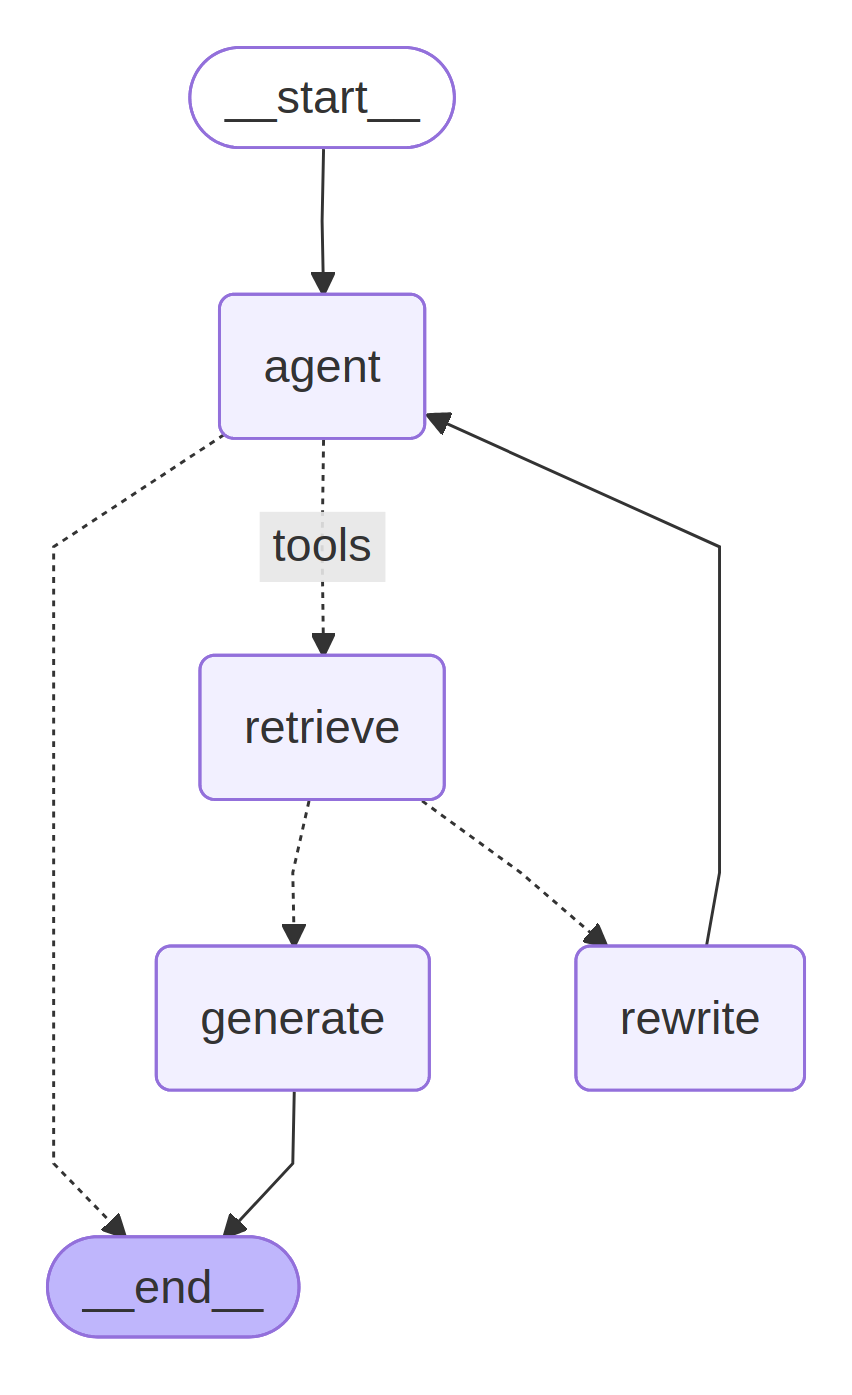

In [52]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langchain_core.runnables.graph import MermaidDrawMethod 


import nest_asyncio
nest_asyncio.apply()

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool,retriever_tool_langchain])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
    {
        # Translate the condition outputs to nodes in our graph
        "generate": "generate",
        "rewrite": "rewrite",
    },
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))


In [53]:
graph.invoke({"messages":"What is Langgraph?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langgraph?', additional_kwargs={}, response_metadata={}, id='bb51000f-faf6-45b9-80d2-0bb5fea6b3c5'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'retriever_vector_db_blog', 'arguments': '{"query": "What is Langgraph?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--0b671617-b38b-4574-8015-c9a0e457b7f7-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'What is Langgraph?'}, 'id': '16b4d97f-3ced-41dc-9d1e-6fe6dcc5f6b0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'output_tokens': 14, 'total_tokens': 70, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='LangSmith Trace\nhttps://smith.langchain.com/public/abab6a44-29f6-4b97-8164-af77413e494d/r\nWhat LangGraph provides¶\nBy constructing each of the above in LangGraph, we get a few things:\nPersistence: Human-in-the-Loop¶\nLangG

In [54]:
graph.invoke({"messages":"What is Langchain?"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What is Langchain?', additional_kwargs={}, response_metadata={}, id='5a0b4595-ab55-41fa-bac5-6cb6d443e5a2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'retriever_vector_langchain_blog', 'arguments': '{"query": "What is Langchain?"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--13662842-cd32-4715-98a2-a76e5c3cae0c-0', tool_calls=[{'name': 'retriever_vector_langchain_blog', 'args': {'query': 'What is Langchain?'}, 'id': 'e7c524d0-9d5a-473c-8099-5ec265114d63', 'type': 'tool_call'}], usage_metadata={'input_tokens': 56, 'output_tokens': 15, 'total_tokens': 71, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='Chat models and prompts: Build a simple LLM application with prompt templates and chat models.\nSemantic search: Build a semantic search engine over a PDF with document loaders, embedding models, and vector store

In [55]:
graph.invoke({"messages":"What is Machine learning?"})

---CALL AGENT---


{'messages': [HumanMessage(content='What is Machine learning?', additional_kwargs={}, response_metadata={}, id='70c55ac5-c8df-4c63-8e18-ca1b0c00121c'),
  AIMessage(content="I can help you with information about Langchain and Langraph. I don't have the ability to provide information about Machine Learning.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--cf1bb2d5-0573-484f-a706-eaefff2fbf2e-0', usage_metadata={'input_tokens': 56, 'output_tokens': 27, 'total_tokens': 83, 'input_token_details': {'cache_read': 0}})]}